### Load Data

In [2]:
!ls /content

celeba.zip  img_align_celeba	  sample_data
drive	    list_attr_celeba.txt  subset_df.csv


In [3]:
# CELEBA DATA LOADER CELL

import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

DATA_ROOT = "/content"   # change if needed
IMG_DIR = os.path.join(DATA_ROOT, "img_align_celeba")
subset_df = pd.read_csv('subset_df.csv', index_col=0)

# TRANSFORM (GAN STANDARD)
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5]
    )
])

# DATASET CLASS
class CelebADataset(Dataset):
    def __init__(self, attr_df, img_dir, transform=None):
        self.attr_df = attr_df
        self.img_dir = img_dir
        self.transform = transform
        self.image_names = attr_df.index.tolist()

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.img_dir, img_name)

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        attrs = self.attr_df.loc[img_name].values
        attrs = torch.tensor(attrs, dtype=torch.float32)

        return image, attrs

# DATASET
dataset = CelebADataset(
    subset_df,
    IMG_DIR,
    transform
)

# DATALOADER
loader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

# DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## DCGAN BASELINE

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from tqdm import tqdm

In [5]:
LATENT_DIM = 100
IMG_CHANNELS = 3
FEATURE_G = 64
FEATURE_D = 64
LR = 2e-4
EPOCHS = 10   # keep small for sprint

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.ConvTranspose2d(LATENT_DIM, FEATURE_G*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(FEATURE_G*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(FEATURE_G*8, FEATURE_G*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FEATURE_G*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(FEATURE_G*4, FEATURE_G*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FEATURE_G*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(FEATURE_G*2, FEATURE_G, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FEATURE_G),
            nn.ReLU(True),

            nn.ConvTranspose2d(FEATURE_G, IMG_CHANNELS, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(IMG_CHANNELS, FEATURE_D, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),

            nn.Conv2d(FEATURE_D, FEATURE_D*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FEATURE_D*2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(FEATURE_D*2, FEATURE_D*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FEATURE_D*4),
            nn.LeakyReLU(0.2),

            nn.Conv2d(FEATURE_D*4, FEATURE_D*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(FEATURE_D*8),
            nn.LeakyReLU(0.2),

            nn.Conv2d(FEATURE_D*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).view(-1)

In [8]:
G = Generator().to(device)
D = Discriminator().to(device)

In [9]:
criterion = nn.BCELoss()

opt_G = optim.Adam(G.parameters(), lr=LR, betas=(0.5, 0.999))
opt_D = optim.Adam(D.parameters(), lr=LR, betas=(0.5, 0.999))

In [10]:
fixed_noise = torch.randn(16, LATENT_DIM, 1, 1, device=device)

Epoch [1/10]: 100%|██████████| 157/157 [00:15<00:00, 10.45it/s, loss_D=0.246, loss_G=3.51] 


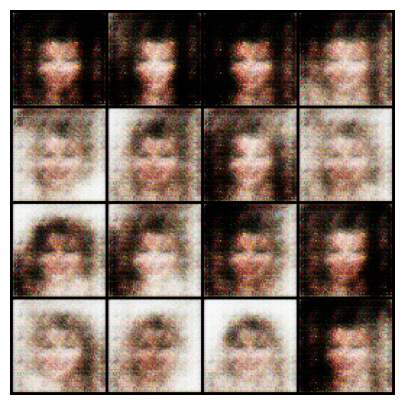

Epoch [2/10]: 100%|██████████| 157/157 [00:14<00:00, 11.21it/s, loss_D=0.143, loss_G=2.17]


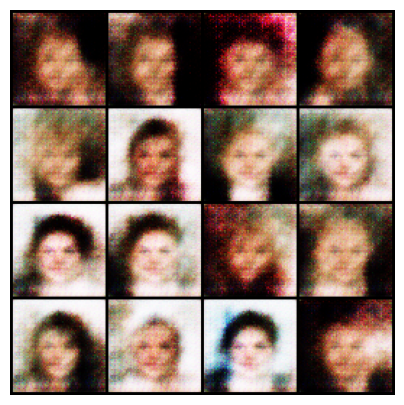

Epoch [3/10]: 100%|██████████| 157/157 [00:14<00:00, 11.21it/s, loss_D=0.601, loss_G=3.18]


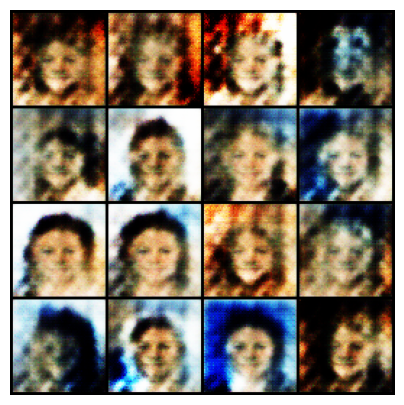

Epoch [4/10]: 100%|██████████| 157/157 [00:13<00:00, 11.25it/s, loss_D=0.473, loss_G=5.9] 


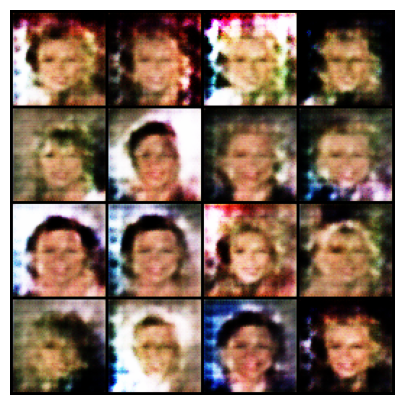

Epoch [5/10]: 100%|██████████| 157/157 [00:13<00:00, 11.33it/s, loss_D=0.182, loss_G=2.73]


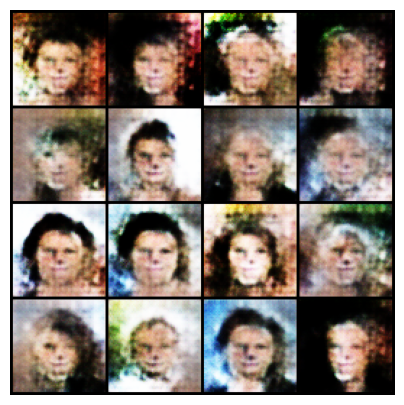

Epoch [6/10]: 100%|██████████| 157/157 [00:13<00:00, 11.50it/s, loss_D=0.366, loss_G=0.969]


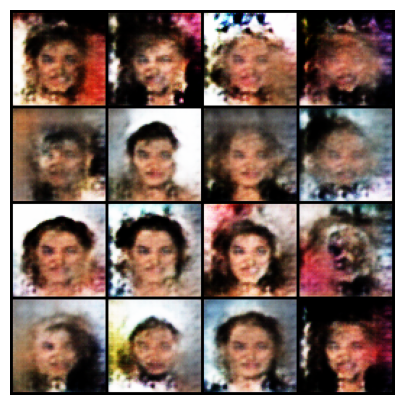

Epoch [7/10]: 100%|██████████| 157/157 [00:13<00:00, 11.81it/s, loss_D=0.328, loss_G=2.63]


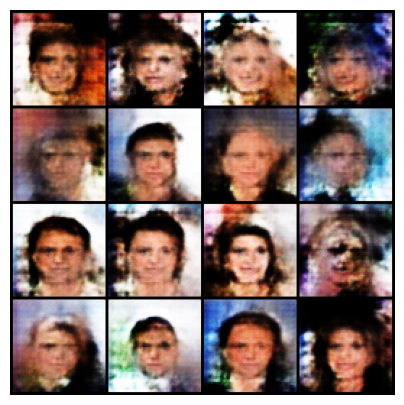

Epoch [8/10]: 100%|██████████| 157/157 [00:13<00:00, 11.80it/s, loss_D=0.238, loss_G=4.42]


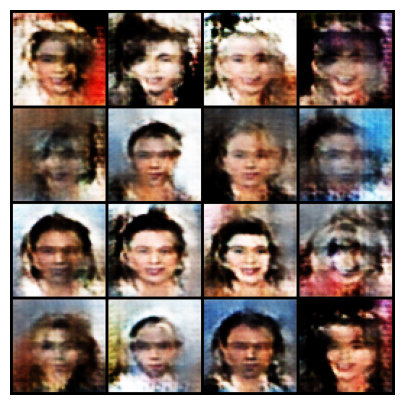

Epoch [9/10]: 100%|██████████| 157/157 [00:13<00:00, 11.96it/s, loss_D=0.363, loss_G=5.16]


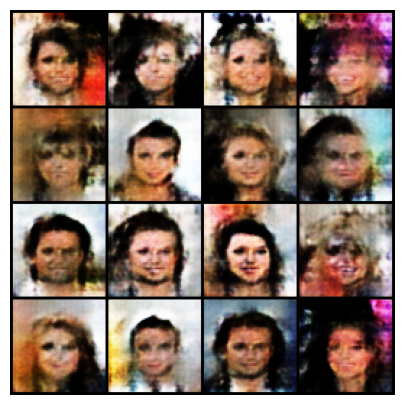

Epoch [10/10]: 100%|██████████| 157/157 [00:13<00:00, 11.51it/s, loss_D=0.464, loss_G=8.79] 


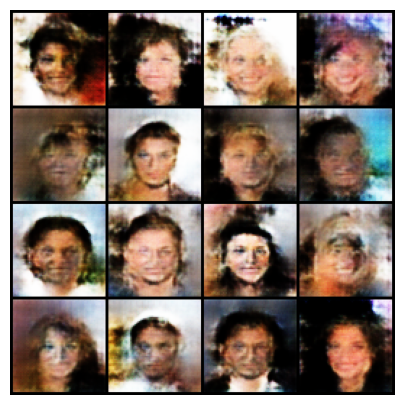

In [11]:
for epoch in range(EPOCHS):

    loop = tqdm(loader)

    for real, _ in loop:

        real = real.to(device)
        batch_size = real.size(0)

        ### Train Discriminator ###
        noise = torch.randn(batch_size, LATENT_DIM, 1, 1, device=device)
        fake = G(noise)

        D_real = D(real)
        D_fake = D(fake.detach())

        loss_D_real = criterion(D_real, torch.ones_like(D_real))
        loss_D_fake = criterion(D_fake, torch.zeros_like(D_fake))

        loss_D = (loss_D_real + loss_D_fake) / 2

        D.zero_grad()
        loss_D.backward()
        opt_D.step()

        ### Train Generator ###
        output = D(fake)
        loss_G = criterion(output, torch.ones_like(output))

        G.zero_grad()
        loss_G.backward()
        opt_G.step()

        loop.set_description(f"Epoch [{epoch+1}/{EPOCHS}]")
        loop.set_postfix(loss_D=loss_D.item(), loss_G=loss_G.item())

    ### Generate Sample Images ###
    with torch.no_grad():
        fake = G(fixed_noise).detach().cpu()
        fake = fake * 0.5 + 0.5

        grid = vutils.make_grid(fake, nrow=4)

        plt.figure(figsize=(5,5))
        plt.imshow(grid.permute(1,2,0))
        plt.axis("off")
        plt.show()